In [1]:
import os
from openpyxl import load_workbook
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('')))
DATA_DIR = os.path.join(BASE_DIR, 'amerigo_island', 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, 'interim')
FINAL_DATA_DIR = os.path.join(DATA_DIR, 'final')

FULL_RESILIENCE_FILENAME = 'full_resilience_df.csv'

In [2]:
load_and_gen_df = pd.read_csv(os.path.join(FINAL_DATA_DIR, FULL_RESILIENCE_FILENAME))

In [3]:
load_w_transmission_loss_and_load_scale_colname = "load_w_transmission_loss_and_load_scale"
gen_thermal_total_mw_colname = "gen_thermal_total_mw"
battery_final_thermal_prod_mw_colname = "battery_final_thermal_prod_mw"
h2_real_thermal_prod_colname = "h2_real_thermal_prod"

thermal_prod_cols = [
    "load_w_transmission_loss_and_load_scale", # all thermal
    "gen_thermal_total_mw", # no storage w proposed sites
    "battery_final_thermal_prod_mw", # battery storage w proposed sites
    "h2_real_thermal_prod" # h2 storage w proposed sites
]
load_and_gen_df[thermal_prod_cols]

,load_w_transmission_loss_and_load_scale,gen_thermal_total_mw,battery_final_thermal_prod_mw,h2_real_thermal_prod
0,35.1,33.42,30.654286,31.0
1,35.1,33.87,30.590000,31.0
2,34.6,33.51,30.641429,31.0
3,34.2,32.73,30.752857,31.0
4,33.8,32.68,30.760000,31.0
...,...,...,...,...
8755,45.5,38.73,29.895714,31.0
8756,46.5,40.29,29.672857,31.0
8757,45.0,36.27,30.247143,31.0
8758,41.7,34.47,30.504286,31.0


In [10]:
no_vre_ramp_rate_mw_colname = 'no_vre_ramp_rate_mw'
no_storage_ramp_rate_mw_colname = 'no_storage_ramp_rate_mw'
battery_ramp_rate_mw_colname = 'battery_ramp_rate_mw'
h2_ramp_rate_mw_colname = 'h2_ramp_rate_mw'


decorated_df = load_and_gen_df.copy()
decorated_df[no_vre_ramp_rate_mw_colname] = None
decorated_df[no_storage_ramp_rate_mw_colname] = None
decorated_df[battery_ramp_rate_mw_colname] = None
decorated_df[h2_ramp_rate_mw_colname] = None

load_w_transmission_loss_and_load_scale_colname = "load_w_transmission_loss_and_load_scale"
gen_thermal_total_mw_colname = "gen_thermal_total_mw"
battery_final_thermal_prod_mw_colname = "battery_final_thermal_prod_mw"
h2_real_thermal_prod_colname = "h2_real_thermal_prod"

for idx, row in decorated_df.iterrows():

    if idx == 0: # First row of data set, so can't take previous hour's values

        no_vre_val, no_storage_val = 0, 0

    else: # Subsequent rows. Has values for previous hour
    
        no_vre_val = abs(decorated_df.loc[idx - 1, load_w_transmission_loss_and_load_scale_colname] - row[load_w_transmission_loss_and_load_scale_colname])
        no_storage_val = abs(decorated_df.loc[idx - 1, gen_thermal_total_mw_colname] - row[gen_thermal_total_mw_colname])
        #batt_val = decorated_df.loc[idx - 1, battery_final_thermal_prod_mw_colname] - row[battery_final_thermal_prod_mw_colname]
        #h2_val = decorated_df.loc[idx - 1, h2_real_thermal_prod_colname] - row[h2_real_thermal_prod_colname]
        
    decorated_df.at[idx, no_vre_ramp_rate_mw_colname] = no_vre_val
    decorated_df.at[idx, no_storage_ramp_rate_mw_colname] = no_storage_val
#     decorated_df.at[idx, battery_ramp_rate_mw_colname] = batt_val
#     decorated_df.at[idx, h2_ramp_rate_mw_colname] = h2_val
    
    decorated_df[no_vre_ramp_rate_mw_colname] = decorated_df[no_vre_ramp_rate_mw_colname].astype(float)
    decorated_df[no_storage_ramp_rate_mw_colname] = decorated_df[no_storage_ramp_rate_mw_colname].astype(float)
#     decorated_df[battery_ramp_rate_mw_colname] = decorated_df[battery_ramp_rate_mw_colname].astype(float)
#     decorated_df[h2_ramp_rate_mw_colname] = decorated_df[h2_ramp_rate_mw_colname].astype(float)


In [11]:
ramp_rate_cols = [
    no_vre_ramp_rate_mw_colname,
    no_storage_ramp_rate_mw_colname,
]

decorated_df[ramp_rate_cols].describe()

,no_vre_ramp_rate_mw,no_storage_ramp_rate_mw
count,8760.000000,8760.000000
mean,1.396016,4.318294
std,1.347558,4.714479
min,0.000000,0.000000
25%,0.400000,0.830000
50%,1.000000,2.470200
75%,2.100000,6.559350
max,20.700000,31.874500


In [15]:
weekly_df = decorated_df.groupby('week').mean()
weekly_df = weekly_df[ramp_rate_cols].reset_index()

In [17]:
weekly_df.describe()

,week,no_vre_ramp_rate_mw,no_storage_ramp_rate_mw
count,52.000000,52.000000,52.000000
mean,26.500000,1.396652,4.317630
std,15.154757,0.196887,0.352246
min,1.000000,1.148810,3.595463
25%,13.750000,1.245982,4.092842
50%,26.500000,1.334821,4.291347
75%,39.250000,1.516369,4.515146
max,52.000000,1.886905,5.223604


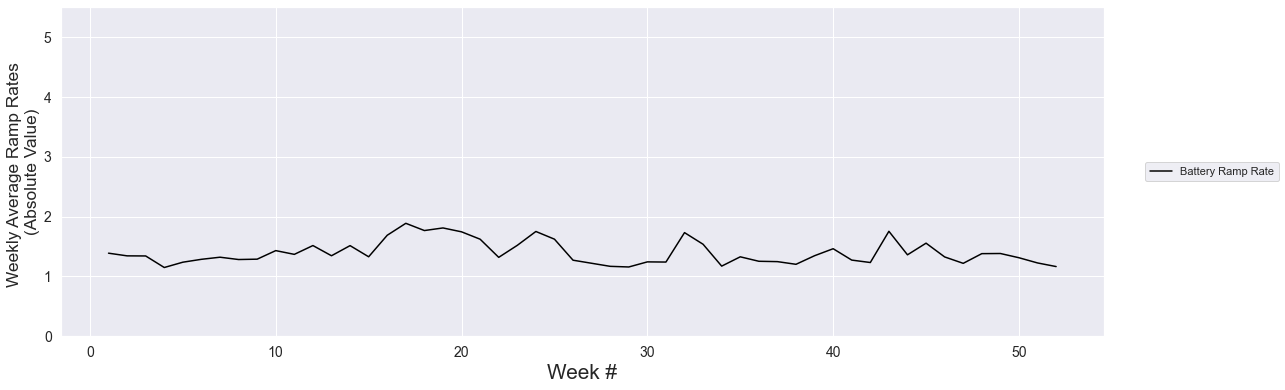

In [18]:
# num_viz = 4
# sns.set(rc={'figure.figsize':(18, 18)})
# fig = plt.figure()
# for i in range(1, num_viz + 1):
#     subplot = fig.add_subplot(num_viz, 1, i)
#     subplot.set_ylim([-13,13])
#     plt.plot("week", ramp_rate_cols[i - 1], label="Ramp Rate - {}".format(ramp_rate_cols[i - 1]), color="black", data=weekly_df)
#     plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#     plt.ylabel("Weekly Average Ramp Rates", fontsize="x-large")
#     plt.xlabel("Week #", fontsize="xx-large")
#     plt.tight_layout()
#     fig.subplots_adjust(top = 0.9, hspace = 0.3)
    
#    no_vre_ramp_rate_mw_colname,
#    no_storage_ramp_rate_mw_colname,
sns.set(rc={'figure.figsize':(18, 6)})
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([0, 5.5])
plt.plot("week", no_vre_ramp_rate_mw_colname, label="Battery Ramp Rate", color="black", data=weekly_df)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.ylabel("Weekly Average Ramp Rates \n(Absolute Value)", fontsize="x-large")
plt.xlabel("Week #", fontsize="xx-large")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.subplots_adjust(top = 0.9, hspace = 0.3) 

Text(0, 0.5, 'Demand (MW)')

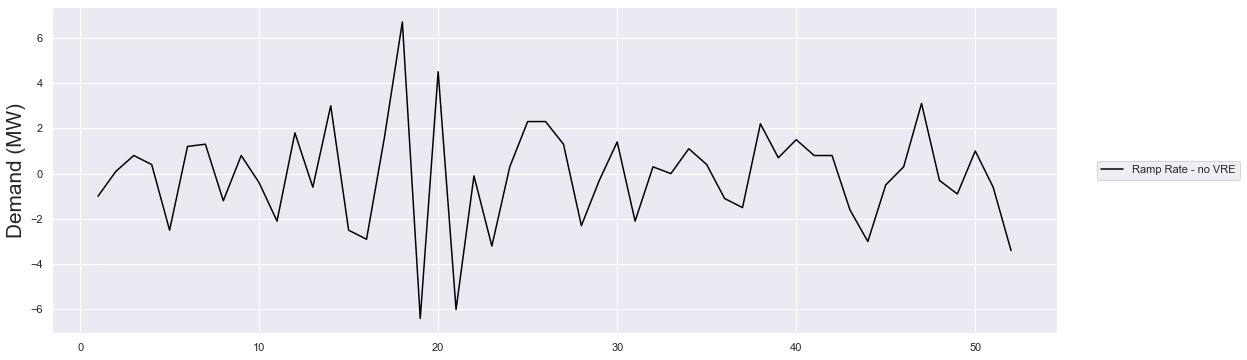

In [10]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
#subplot.set_ylim([0,35])
plt.plot("week", no_vre_ramp_rate_mw_colname, label="Ramp Rate - no VRE", color="black", data=weekly_df)


plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.ylabel("Demand (MW)", fontsize="xx-large")


# plt.xlabel("Date", fontsize="xx-large")
# plt.xticks(fontsize=16)
# plt.title("Resilience Case: Maximum Weekly Load", fontdict={"fontweight": "bold", "fontsize": 20})

# fig.subplots_adjust(top = 0.9, hspace = 0.3)
# plt.tight_layout()

In [75]:
len(weekly_df[no_vre_ramp_rate_mw_colname])

52